#### Modules and definitions

In [76]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Machine learning modules
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, LeaveOneGroupOut, learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier

# Function to load and preprocess images
def load_image(image_path, resize_shape=None):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # 00 image in grayscale
    if resize_shape is not None:
        image = cv2.resize(image, resize_shape)  # Resize image to a fixed size
    return image.flatten()  # Flatten image to a 1D array

# General random_state for reproducibility
random_state = 0

#### Load dataset of image labels

In [11]:
# Step 1: Load your dataset using pandas
# Assuming your dataset is in CSV format

dataset_path = "data/splits/sgkf-50-25-25-size-800/images.csv"
df = pd.read_csv(dataset_path, index_col=0)

#### Sample the dataset per camera

In [13]:
n_camera_samples = 10

# Regular sample
# n_cameras = len(df['code'].unique())
# n_samples = n_cameras * n_camera_samples
# df_sample = df.sample(, replace=False, random_state=random_state)

# Sample per camera
code_samples = []
for code in df['code'].unique():
    camera_sample = df[df['code'] == code].sample(n_camera_samples, replace=False, random_state=random_state)
    code_samples.append(camera_sample)
df_sample = pd.concat(code_samples)

print('Nº of Cameras:', len(df_sample['code'].unique()))
print('Nº of Samples:', len(df_sample))
pd.concat([df_sample['code'].value_counts().rename('Sample'), df['code'].value_counts().rename('Total')], axis=1).T

Nº of Cameras: 30
Nº of Samples: 300


code,235.0,1393.0,1881.0,3133.0,442.0,94.0,326.0,1538.0,278.0,1475.0,...,1606.0,1994.0,339.0,310.0,384.0,1083.0,267.0,92.0,298.0,1119.0
Sample,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Total,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


#### Load and convert images to flat numpy arrays

In [77]:
# ---
# Parameters
base_dir = 'data/images'
resize_shape = (258, 258)
image_paths = df_sample['file_path'].map(lambda path: f'{base_dir}/{path}') # paths to images
labels = df_sample['flood'] # image labels

# List to store image data and file paths
images = []

# Loop through each image path
for path in image_paths:
    try:
        image = load_image(path, resize_shape)  # Load and preprocess image
        images.append(image)  # Append flattened image to list
        # labels.append(label)  # Append label to list
        print(f'Loaded: {len(images)}/{len(image_paths)}', end='\r')
    except Exception as e:
        print(f"Error loading image '{path}': {e}")

# Convert lists to numpy arrays
images = np.array(images)

#### Convert images to pandas dataframe

In [78]:
# Create DataFrame
data = pd.DataFrame(images)
data['label'] = labels.values

# Display DataFrame
display(data.head())

,0,1,2,3,4,5,6,7,8,9,...,66555,66556,66557,66558,66559,66560,66561,66562,66563,label
0,3,7,2,37,32,36,41,34,37,38,...,66,66,65,64,61,60,60,60,60,0
1,5,8,5,38,41,43,41,43,48,42,...,20,20,23,16,14,16,25,59,115,1
2,6,9,3,28,29,34,32,32,34,35,...,28,28,28,28,28,28,28,28,28,1
3,2,6,4,21,23,32,30,26,29,27,...,38,38,37,39,39,37,36,36,36,1
4,6,7,8,129,124,133,130,136,136,137,...,56,56,58,53,53,53,51,51,51,0


#### Set split strategy

In [79]:
test_prct = 0.20
n_splits_test = int(1.0 / test_prct)

gkf = GroupKFold(n_splits=n_splits_test)
sgkf = StratifiedGroupKFold(n_splits=n_splits_test, shuffle=True, random_state=random_state)
logo = LeaveOneGroupOut()

# Choose data split algorithm
splitter = sgkf

print('\nSplit Strategy:', sgkf, '\n')


Split Strategy: StratifiedGroupKFold(n_splits=5, random_state=0, shuffle=True) 



#### Fit and evaluate model for each split for increasing train size

In [80]:
# Step 2: Preprocess your data and split it into features and target variable
# Assuming the last column is the target variable and rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values   # Target variable

# Step 3: Define your machine learning model
model = SGDClassifier(loss='hinge', penalty='l1')
# model = LinearSVC()
# model = SVC(kernel='rbf', gamma='auto')

# Step 4: Define model pipeline
pipe = make_pipeline(StandardScaler(), model)
print(f'\nModel Hyperparameters:\n')
display(model.get_params()); print()

# Step 5: Use the learning_curve function to generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 0.5, 5),  # Varying training set sizes
    cv=splitter,  # Number of cross-validation folds
    scoring='recall',  # Scoring metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=True,
    shuffle=True,
    groups=df_sample['code'].values,
    random_state=random_state,
    error_score='raise',
)


Model Hyperparameters:



{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l1',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


[learning_curve] Training set sizes: [ 24  48  72  96 120]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.9s finished


---
## Visualize results

#### Display learning curves

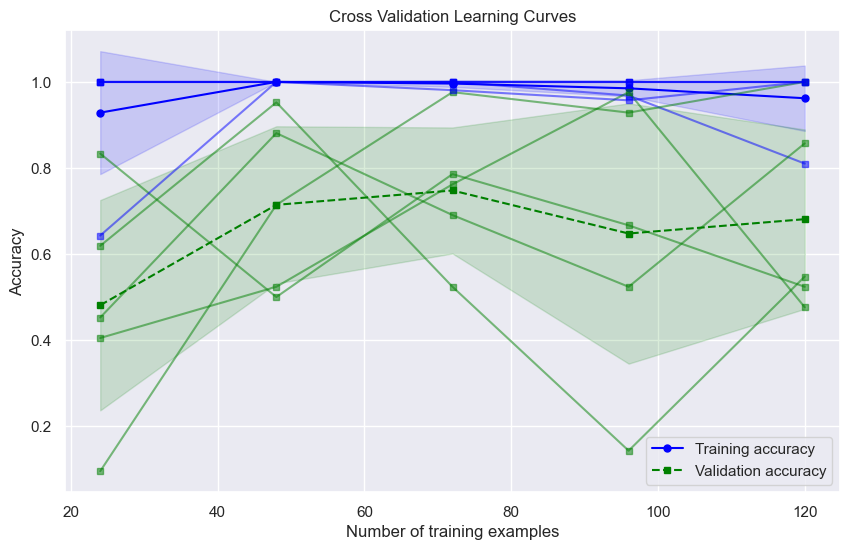

In [81]:
# Calculate mean and standard deviation of training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')

for i in range(len(train_scores[0])):
    plt.plot(train_sizes, train_scores[:, i], marker='s', markersize=5, alpha=0.50, color='blue')
    plt.plot(train_sizes, test_scores[:, i], marker='s', markersize=5, alpha=0.50, color='green')

plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.title('Cross Validation Learning Curves')
plt.legend(loc='lower right')
# plt.grid()
plt.show()

#### Display evaluation metrics

In [69]:
print('\nTrain Scores:')
display(pd.DataFrame(train_scores, index=pd.Series(train_sizes, name='Train Size')))
print('\nTest Scores:')
display(pd.DataFrame(test_scores, index=pd.Series(train_sizes, name='Train Size')))



Train Scores:


,0,1,2,3,4
Train Size,,,,,
24,1.0,0.714286,1.000000,1.000000,1.000000
48,1.0,1.000000,1.000000,0.885714,0.970588
72,1.0,0.958333,0.933333,1.000000,0.980392
96,1.0,0.841270,0.968254,1.000000,0.895522
120,1.0,1.000000,1.000000,0.895349,1.000000



Test Scores:


,0,1,2,3,4
Train Size,,,,,
24,0.547619,0.404762,0.952381,1.000000,0.595238
48,0.452381,0.809524,0.833333,0.333333,1.000000
72,0.833333,0.761905,0.523810,0.857143,0.428571
96,0.738095,0.785714,0.523810,0.642857,0.238095
120,0.785714,1.000000,0.785714,0.000000,0.428571
